In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import itertools
import os
import shutil
import random
import timeit
import glob
import matplotlib.pyplot as plt 
import warnings
from recurrence_plot import RecurrencePlot as rp
#warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline

### Check for compatable GPU (optional)

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


### Declare global variables

In [19]:
chaos_labels = np.array([1,0,0])
period_labels = np.array([0,1,0])
trend_labels = np.array([0,0,1])

chaos_path = 'rp-data/chaos'
period_path = 'rp-data/period'
trend_path = 'rp-data/trend'

train_samples_path = 'rp-data/train_samples.npy'
train_labels_path = 'rp-data/train_labels.npy'

In [61]:
def binarize_image_array(pixels_array):
    graph_list = []
    triangle_width = len(pixels_array) - 1

    for i in range(triangle_width):
        for j in range(triangle_width - i):
            pixel = 1
            if (pixels_array[i][j][0] == np.float32(255)):
                pixel = 0
             
            graph_list.append(pixel)
            
    return graph_list
    

def populate_train_data(image_dir, train_label):
    counter = 0
    t_start = timeit.default_timer()
    t_samples, t_labels = [], []
    
    for file in os.listdir(image_dir):
        filename = os.fsdecode(file)
        
        if filename.endswith(".png"):
            counter += 1
            
            img_path = os.path.join(image_dir, filename)
            img = load_img(img_path)
            
            pixels_array = img_to_array(img)
            pixels_array_binarized = binarize_image_array(pixels_array)
            
            t_samples.append(pixels_array_binarized)
            t_labels.append(train_label)
            append_to_csv
            if (counter % 50 == 0):
                print("Time taken: ", timeit.default_timer()-t_start\
                     ,'\tImages processed: ', counter)

    t_end = timeit.default_timer()
    print("Total time taken: ", t_end - t_start)
    
    t_samples = np.array(t_samples, dtype=np.uint8)
    t_labels = np.array(t_labels, dtype=np.uint8)
    
    return [t_samples, t_labels]

chaos_data = populate_train_data(chaos_path, chaos_labels)
period_data = populate_train_data(period_path, period_labels)
trend_data = populate_train_data(trend_path, trend_labels)

train_samples = np.concatenate((chaos_data[0], period_data[0], trend_data[0]), axis=0)
train_labels = np.concatenate((chaos_data[1], period_data[1], trend_data[1]))

np.save(train_samples_path, train_samples)
np.save(train_labels_path, train_labels)

Time taken:  9.532715523000661 	Images processed:  50
Time taken:  19.238121677999516 	Images processed:  100
Time taken:  28.915293907000887 	Images processed:  150
Time taken:  38.61049524600094 	Images processed:  200
Time taken:  48.19825645000128 	Images processed:  250
Time taken:  57.891139757999554 	Images processed:  300
Time taken:  67.80650453099952 	Images processed:  350
Time taken:  77.81475714000044 	Images processed:  400
Time taken:  87.67279013400002 	Images processed:  450
Time taken:  97.29572284200003 	Images processed:  500
Time taken:  107.0885969789997 	Images processed:  550
Time taken:  116.96589659300116 	Images processed:  600
Time taken:  126.52268294399983 	Images processed:  650
Time taken:  136.41931368900077 	Images processed:  700
Time taken:  146.36977546799972 	Images processed:  750
Time taken:  156.45282599500024 	Images processed:  800
Time taken:  166.3962967410007 	Images processed:  850
Time taken:  176.17865518399958 	Images processed:  900
Ti

### Load train data into numpy arrays

In [62]:
ttrain_samples = np.load(train_samples_path)
ttrain_labels = np.load(train_labels_path)

# Convert Images to integeras (0 or 1) numpy arary

In [24]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
               .flow_from_directory(directory=train_path, target_size=(224,224), classes=['periodic', 'trend'], batch_size=10, shuffle=True)
#.flow_from_directory(directory=train_path, target_size=(224,224), classes=['periodic', 'trend', 'chaotic'], batch_size=10, shuffle=True)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
               .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['periodic', 'trend'], batch_size=10, shuffle=True)
#                .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['periodic', 'trend', 'chaotic'], batch_size=10, shuffle=True)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
               .flow_from_directory(directory=test_path, target_size=(224,224), classes=['periodic', 'trend'], batch_size=10, shuffle=True)
#.flow_from_directory(directory=test_path, target_size=(224,224), classes=['periodic', 'trend', 'chaotic'], batch_size=10, shuffle=True)

Found 1700 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [25]:
print(train_batches.next())

(array([[[[ 151.061  ,  138.22101,  131.32   ],
         [-103.939  , -116.779  , -123.68   ],
         [ 151.061  ,  138.22101,  131.32   ],
         ...,
         [ 151.061  ,  138.22101,  131.32   ],
         [ 151.061  ,  138.22101,  131.32   ],
         [-103.939  , -116.779  , -123.68   ]],

        [[ 151.061  ,  138.22101,  131.32   ],
         [-103.939  , -116.779  , -123.68   ],
         [-103.939  , -116.779  , -123.68   ],
         ...,
         [ 151.061  ,  138.22101,  131.32   ],
         [-103.939  , -116.779  , -123.68   ],
         [ 151.061  ,  138.22101,  131.32   ]],

        [[ 151.061  ,  138.22101,  131.32   ],
         [ 151.061  ,  138.22101,  131.32   ],
         [-103.939  , -116.779  , -123.68   ],
         ...,
         [-103.939  , -116.779  , -123.68   ],
         [ 151.061  ,  138.22101,  131.32   ],
         [ 151.061  ,  138.22101,  131.32   ]],

        ...,

        [[ 151.061  ,  138.22101,  131.32   ],
         [ 151.061  ,  138.22101,  131.32   

In [26]:
imgs, labels = next(train_batches)

In [20]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


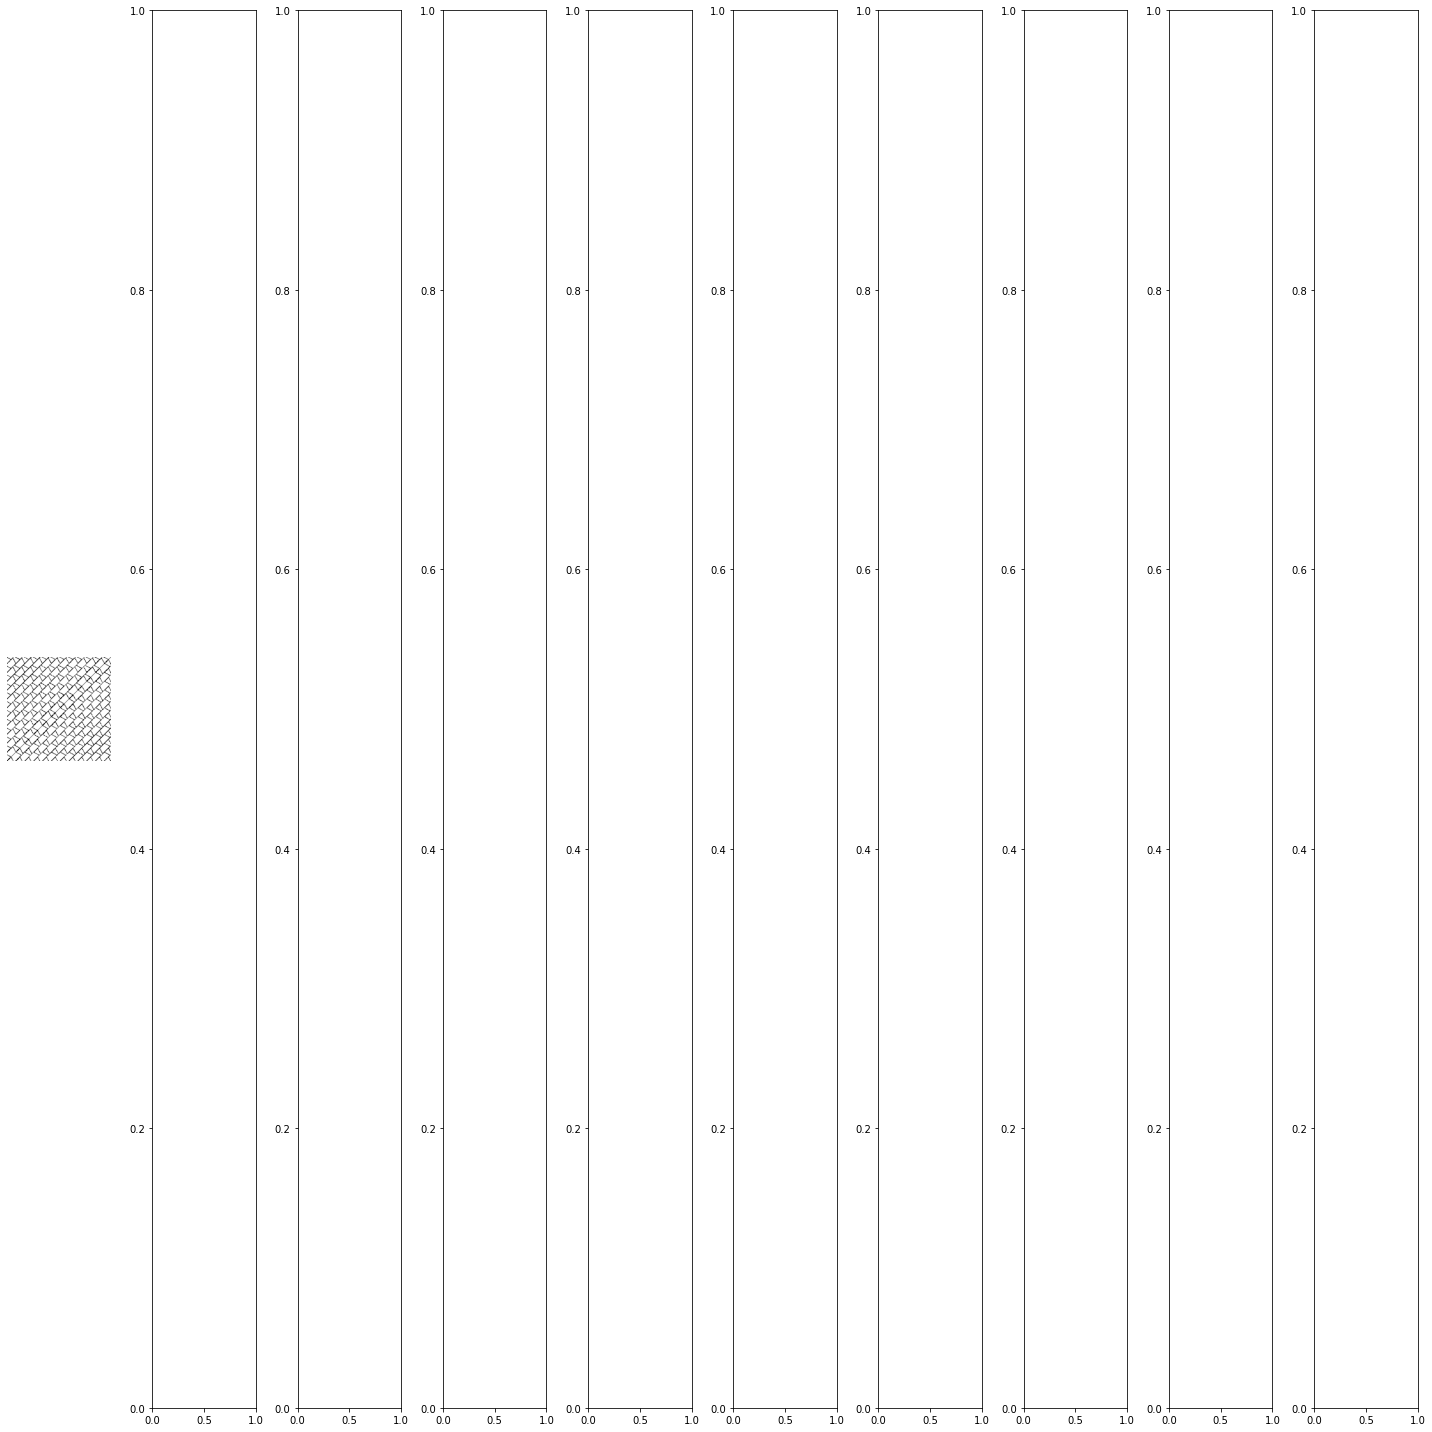

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [15]:
#plotImages(imgs)
#print(labels)

In [28]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
________________________________________________

In [29]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=Adam(learning_rate=0.0001),
#              loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [30]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
170/170 - 8s - loss: 4.7100 - accuracy: 0.9829 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
170/170 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
170/170 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
170/170 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
170/170 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
170/170 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
170/170 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8/10
170/170 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9/10
170/170 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 10/10
170/170 - 8s - loss:

# Predict

In [16]:
predictions = model.predict(x=test_batches, verbose=0)

In [17]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.